<a href="https://colab.research.google.com/github/pranay8297/Capstone/blob/pr/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import collections.abc
import math
import copy
from typing import Dict, List, Optional, Set, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# Vision Transformer Encoder


In [2]:
from collections import OrderedDict
from typing import Mapping
from packaging import version

from transformers.activations import ACT2FN
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling, ImageClassifierOutput, MaskedImageModelingOutput
from transformers.modeling_utils import PreTrainedModel
from transformers.configuration_utils import PretrainedConfig
from transformers.onnx import OnnxConfig
from transformers.utils import logging
from transformers.pytorch_utils import find_pruneable_heads_and_indices, prune_linear_layer
from transformers.utils import add_code_sample_docstrings, add_start_docstrings, add_start_docstrings_to_model_forward, logging, replace_return_docstrings

In [3]:
class ViTConfig(PretrainedConfig):

    model_type = "vit"

    def __init__(
        self,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        hidden_act="gelu",
        hidden_dropout_prob=0.0,
        attention_probs_dropout_prob=0.0,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        image_size=224,
        patch_size=16,
        num_channels=3,
        qkv_bias=True,
        encoder_stride=16,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_act = hidden_act
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.qkv_bias = qkv_bias
        self.encoder_stride = encoder_stride

In [4]:
class ViTPatchEmbeddings(nn.Module):

    def __init__(self, config):
        super().__init__()
        image_size, patch_size = config.image_size, config.patch_size
        num_channels, hidden_size = config.num_channels, config.hidden_size

        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False):
        batch_size, num_channels, height, width = pixel_values.shape
        if num_channels != self.num_channels:
            raise ValueError(
                "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
                f" Expected {self.num_channels} but got {num_channels}."
            )
        if not interpolate_pos_encoding:
            if height != self.image_size[0] or width != self.image_size[1]:
                raise ValueError(
                    f"Input image size ({height}*{width}) doesn't match model"
                    f" ({self.image_size[0]}*{self.image_size[1]})."
                )
        embeddings = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return embeddings

class ViTEmbeddings(nn.Module):

    def __init__(self, config: ViTConfig, use_mask_token: bool = False):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size)) if use_mask_token else None
        self.patch_embeddings = ViTPatchEmbeddings(config)
        num_patches = self.patch_embeddings.num_patches
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, config.hidden_size))
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.config = config

    def interpolate_pos_encoding(self, embeddings: torch.Tensor, height: int, width: int):

        num_patches = embeddings.shape[1] - 1
        num_positions = self.position_embeddings.shape[1] - 1

        if num_patches == num_positions and height == width:
            return self.position_embeddings

        class_pos_embed = self.position_embeddings[:, 0]
        patch_pos_embed = self.position_embeddings[:, 1:]
        dim = embeddings.shape[-1]
        h0 = height // self.config.patch_size
        w0 = width // self.config.patch_size
        # we add a small number to avoid floating point error in the interpolation

        h0, w0 = h0 + 0.1, w0 + 0.1
        patch_pos_embed = patch_pos_embed.reshape(1, int(math.sqrt(num_positions)), int(math.sqrt(num_positions)), dim)
        patch_pos_embed = patch_pos_embed.permute(0, 3, 1, 2)
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed,
            scale_factor=(h0 / math.sqrt(num_positions), w0 / math.sqrt(num_positions)),
            mode="bicubic",
            align_corners=False,
        )
        assert int(h0) == patch_pos_embed.shape[-2] and int(w0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def forward(
        self,
        pixel_values: torch.Tensor,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        interpolate_pos_encoding: bool = False,
    ):
        batch_size, num_channels, height, width = pixel_values.shape
        embeddings = self.patch_embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)

        if bool_masked_pos is not None:
            seq_length = embeddings.shape[1]
            mask_tokens = self.mask_token.expand(batch_size, seq_length, -1)
            # replace the masked visual tokens by mask_tokens
            mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            embeddings = embeddings * (1.0 - mask) + mask_tokens * mask

        # add the [CLS] token to the embedded patch tokens
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)

        # add positional encoding to each token
        if interpolate_pos_encoding:
            embeddings = embeddings + self.interpolate_pos_encoding(embeddings, height, width)
        else:
            embeddings = embeddings + self.position_embeddings

        embeddings = self.dropout(embeddings)

        return embeddings

In [5]:
class ViTSelfAttention(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size {config.hidden_size,} is not a multiple of the number of attention "
                f"heads {config.num_attention_heads}."
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)
        self.key = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)
        self.value = nn.Linear(config.hidden_size, self.all_head_size, bias=config.qkv_bias)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x: torch.Tensor):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self, hidden_states, head_mask: Optional[torch.Tensor] = None, output_attentions: bool = False
    ):
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

class ViTSelfOutput(nn.Module):

    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states

class ViTAttention(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.attention = ViTSelfAttention(config)
        self.output = ViTSelfOutput(config)
        self.pruned_heads = set()

    def prune_heads(self, heads: Set[int]) -> None:
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_outputs = self.attention(hidden_states, head_mask, output_attentions)

        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

class ViTIntermediate(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)

        return hidden_states

class ViTOutput(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

In [6]:
class ViTLayer(nn.Module):

    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = ViTAttention(config)
        self.intermediate = ViTIntermediate(config)
        self.output = ViTOutput(config)
        self.layernorm_before = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + outputs

        return outputs

class ViTPooler(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class ViTEncoder(nn.Module):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ViTLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = True,
    ) -> Union[tuple, BaseModelOutput]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    layer_module.__call__,
                    hidden_states,
                    layer_head_mask,
                    output_attentions,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

In [7]:
class ViTModel(PreTrainedModel):
    main_input_name = 'pixel_values'

    def __init__(self, config: ViTConfig, add_pooling_layer: bool = True, use_mask_token: bool = False):
        super().__init__(config)
        self.config = config

        self.embeddings = ViTEmbeddings(config, use_mask_token=use_mask_token)
        # Get the embeddings of each patch within a batch
        self.encoder = ViTEncoder(config)

        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pooler = ViTPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def _init_weights(self, module: Union[nn.Linear, nn.Conv2d, nn.LayerNorm]) -> None:
        """Initialize the weights"""
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Upcast the input in `fp32` and cast it back to desired `dtype` to avoid
            # `trunc_normal_cpu` not implemented in `half` issues
            module.weight.data = nn.init.trunc_normal_(
                module.weight.data.to(torch.float32), mean=0.0, std=self.config.initializer_range
            ).to(module.weight.dtype)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, ViTEmbeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config.initializer_range,
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config.initializer_range,
            ).to(module.cls_token.dtype)

    def get_input_embeddings(self) -> ViTPatchEmbeddings:
        return self.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune: Dict[int, List[int]]) -> None:
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)
    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`, *optional*):
            Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        # TODO: maybe have a cleaner way to cast the input (from `ImageProcessor` side?)
        expected_dtype = self.embeddings.patch_embeddings.projection.weight.dtype
        if pixel_values.dtype != expected_dtype:
            pixel_values = pixel_values.to(expected_dtype)

        embedding_output = self.embeddings(
            pixel_values, bool_masked_pos=bool_masked_pos, interpolate_pos_encoding=interpolate_pos_encoding
        )

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
            return head_outputs + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )


In [8]:
encoder_config = {
    "_name_or_path": "",
    "add_cross_attention": False,
    "architectures": None,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": None,
    "begin_suppress_tokens": None,
    "bos_token_id": None,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": None,
    "decoder_start_token_id": None,
    "diversity_penalty": 0.0,
    "do_sample": False,
    "early_stopping": False,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 16,
    "eos_token_id": None,
    "exponential_decay_length_penalty": None,
    "finetuning_task": None,
    "forced_bos_token_id": None,
    "forced_eos_token_id": None,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "image_size": 384,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "is_decoder": False,
    "is_encoder_decoder": False,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1
    },"layer_norm_eps": 1e-12,
    "length_penalty": 1.0,
    "max_length": 20,
    "min_length": 0,
    "model_type": "vit",
    "no_repeat_ngram_size": 0,
    "num_attention_heads": 12,
    "num_beam_groups": 1,
    "num_beams": 1,
    "num_channels": 3,
    "num_hidden_layers": 12,
    "num_return_sequences": 1,
    "output_attentions": False,
    "output_hidden_states": False,
    "output_scores": False,
    "pad_token_id": None,
    "patch_size": 16,
    "prefix": None,
    "problem_type": None,
    "pruned_heads": {},
    "qkv_bias": False,
    "remove_invalid_values": False,
    "repetition_penalty": 1.0,
    "return_dict": True,
    "return_dict_in_generate": False,
    "sep_token_id": None,
    "suppress_tokens": None,
    "task_specific_params": None,
    "temperature": 1.0,
    "tf_legacy_loss": None,
    "tie_encoder_decoder": None,
    "tie_word_embeddings": None,
    "tokenizer_class": None,
    "top_k": 50,
    "top_p": 1.0,
    "torch_dtype": None,
    "torchscript": False,
    "typical_p": 1.0,
    "use_bfloat16": False
  }

In [9]:
config = ViTConfig(**encoder_config)

In [10]:
encoder = ViTModel(config)

# Transformer Decoder Model

In [11]:
from transformers.activations import ACT2FN
from transformers.modeling_attn_mask_utils import _prepare_4d_attention_mask, _prepare_4d_causal_attention_mask
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions, CausalLMOutputWithCrossAttentions
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import add_start_docstrings, logging, replace_return_docstrings
from transformers.configuration_utils import PretrainedConfig

In [12]:
class TrOCRConfig(PretrainedConfig):

    model_type = "trocr"
    keys_to_ignore_at_inference = ["past_key_values"]
    attribute_map = {
        "num_attention_heads": "decoder_attention_heads",
        "hidden_size": "d_model",
        "num_hidden_layers": "decoder_layers",
    }

    def __init__(
        self,
        vocab_size=50265,
        d_model=1024,
        decoder_layers=12,
        decoder_attention_heads=16,
        decoder_ffn_dim=4096,
        activation_function="gelu",
        max_position_embeddings=512,
        dropout=0.1,
        attention_dropout=0.0,
        activation_dropout=0.0,
        decoder_start_token_id=2,
        init_std=0.02,
        decoder_layerdrop=0.0,
        use_cache=True,
        scale_embedding=False,
        use_learned_position_embeddings=True,
        layernorm_embedding=True,
        pad_token_id=1,
        bos_token_id=0,
        eos_token_id=2,
        **kwargs,
    ):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.decoder_layers = decoder_layers
        self.decoder_attention_heads = decoder_attention_heads
        self.decoder_ffn_dim = decoder_ffn_dim
        self.activation_function = activation_function
        self.max_position_embeddings = max_position_embeddings
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.activation_dropout = activation_dropout
        self.init_std = init_std
        self.decoder_layerdrop = decoder_layerdrop
        self.use_cache = use_cache
        self.scale_embedding = scale_embedding
        self.use_learned_position_embeddings = use_learned_position_embeddings
        self.layernorm_embedding = layernorm_embedding

        super().__init__(
            pad_token_id=pad_token_id,
            bos_token_id=bos_token_id,
            eos_token_id=eos_token_id,
            decoder_start_token_id=decoder_start_token_id,
            **kwargs,
        )

class TrOCRLearnedPositionalEmbedding(nn.Embedding):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, num_embeddings: int, embedding_dim: int):
        # TrOCR is set up so that if padding_idx is specified then offset the embedding ids by 2
        # and adjust num_embeddings appropriately. Other models don't have this hack
        self.offset = 2
        super().__init__(num_embeddings + self.offset, embedding_dim)

    def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
        """`input_ids' shape is expected to be [bsz x seqlen]."""

        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        ).expand(bsz, -1)

        return super().forward(positions + self.offset)

class TrOCRSinusoidalPositionalEmbedding(nn.Module):
    """This module produces sinusoidal positional embeddings of any length."""

    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None):
        super().__init__()
        self.offset = 2
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.weights = self.get_embedding(num_positions, embedding_dim, padding_idx)
        self.register_buffer("_float_tensor", torch.FloatTensor(1))

    @staticmethod
    def get_embedding(num_embeddings: int, embedding_dim: int, padding_idx: Optional[int] = None):
        """
        Build sinusoidal embeddings. This matches the implementation in tensor2tensor, but differs slightly from the
        description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float) * -emb)
        emb = torch.arange(num_embeddings, dtype=torch.float).unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1).view(num_embeddings, -1)
        if embedding_dim % 2 == 1:
            # zero pad
            emb = torch.cat([emb, torch.zeros(num_embeddings, 1)], dim=1)
        if padding_idx is not None:
            emb[padding_idx, :] = 0

        return emb.to(torch.get_default_dtype())

    @torch.no_grad()
    def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
        bsz, seq_len = input_ids.size()
        # Create the position ids from the input token ids. Any padded tokens remain padded.
        position_ids = self.create_position_ids_from_input_ids(input_ids, self.padding_idx, past_key_values_length).to(
            input_ids.device
        )

        # expand embeddings if needed
        max_pos = self.padding_idx + 1 + seq_len
        if self.weights is None or max_pos > self.weights.size(0):
            # recompute/expand embeddings if needed
            self.weights = self.get_embedding(max_pos, self.embedding_dim, self.padding_idx)
        self.weights = self.weights.to(self._float_tensor)

        x = self.weights.index_select(0, position_ids.view(-1)).view(bsz, seq_len, -1).detach()

        return x

    def create_position_ids_from_input_ids(
        self, input_ids: torch.Tensor, padding_idx: int, past_key_values_length: Optional[int] = 0
    ):
        """
        Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx+1. Padding
        symbols are ignored. This is modified from fairseq's `utils.make_positions`.
        """
        # The series of casts and type-conversions here are carefully balanced to both work with ONNX export and XLA.
        mask = input_ids.ne(padding_idx).int()
        incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
        return incremental_indices.long() + padding_idx

class TrOCRAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper."""

    def __init__(
        self,
        config,
        embed_dim: int,
        num_heads: int,
        kdim: int = None,
        vdim: int = None,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
        is_cross_attention: bool = False,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        if not (self.head_dim * num_heads == self.embed_dim):
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder

        self.k_proj = nn.Linear(self.kdim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        bsz, tgt_len, embed_dim = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value

class TrOCRDecoderLayer(nn.Module):
    def __init__(self, config: TrOCRConfig):
        super().__init__()
        self.embed_dim = config.hidden_size

        self.self_attn = TrOCRAttention(
            config,
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)

        if config.is_decoder:
            self.encoder_attn = TrOCRAttention(
                config,
                embed_dim=self.embed_dim,
                num_heads=config.decoder_attention_heads,
                kdim=config.cross_attention_hidden_size,
                vdim=config.cross_attention_hidden_size,
                dropout=config.attention_dropout,
                is_decoder=True,
                is_cross_attention=True,
            )
            self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)

        self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
        self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size *(decoder_attention_heads,)*.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None

        if encoder_hidden_states is not None:
            residual = hidden_states

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )

            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs

class TrOCRPreTrainedModel(PreTrainedModel):
    config_class = TrOCRConfig
    base_model_prefix = "model"
    supports_gradient_checkpointing = True

    def _init_weights(self, module):
        std = self.config.init_std
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()

class TrOCRDecoder(TrOCRPreTrainedModel):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`TrOCRDecoderLayer`]

    Args:
        config: TrOCRConfig
    """

    def __init__(self, config: TrOCRConfig):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        self.padding_idx = config.pad_token_id
        self.embed_scale = math.sqrt(config.hidden_size) if config.scale_embedding else 1.0

        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size, self.padding_idx)

        if config.use_learned_position_embeddings:
            self.embed_positions = TrOCRLearnedPositionalEmbedding(config.max_position_embeddings, config.hidden_size)
        else:
            self.embed_positions = TrOCRSinusoidalPositionalEmbedding(
                config.max_position_embeddings + self.padding_idx + 1,
                config.hidden_size,
                self.padding_idx,
            )

        if config.layernorm_embedding:
            self.layernorm_embedding = nn.LayerNorm(config.hidden_size)
        else:
            self.layernorm_embedding = None

        self.layers = nn.ModuleList([TrOCRDecoderLayer(config) for _ in range(config.decoder_layers)])

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        inputs_embeds=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            input = input_ids
            input_ids = input_ids.view(-1, input.shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            input = inputs_embeds[:, :, -1]
        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids) * self.embed_scale

        if self.config.use_learned_position_embeddings:
            embed_pos = self.embed_positions(input, past_key_values_length=past_key_values_length)
        else:
            embed_pos = self.embed_positions(input_ids, past_key_values_length=past_key_values_length)

        hidden_states = inputs_embeds + embed_pos

        if self.layernorm_embedding is not None:
            hidden_states = self.layernorm_embedding(hidden_states)

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        input_shape = input.shape

        attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            encoder_attention_mask = _prepare_4d_attention_mask(
                encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
            )

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`..."
                )
                use_cache = False

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                if attn_mask.size()[0] != (len(self.layers)):
                    raise ValueError(
                        f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                        f" {head_mask.size()[0]}."
                    )
        for idx, decoder_layer in enumerate(self.layers):
            #    LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:
                    continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,
                    output_attentions,
                    use_cache,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )

class TrOCRDecoderWrapper(TrOCRPreTrainedModel):
    """
    This wrapper class is a helper class to correctly load pretrained checkpoints when the causal language model is
    used in combination with the [`EncoderDecoderModel`] framework.
    """

    def __init__(self, config):
        super().__init__(config)
        self.decoder = TrOCRDecoder(config)

    def forward(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)

class TrOCRForCausalLM(TrOCRPreTrainedModel):
    _tied_weights_keys = ["output_projection.weight"]

    def __init__(self, config):
        config = copy.deepcopy(config)
        config.is_decoder = True
        config.is_encoder_decoder = False
        super().__init__(config)
        self.model = TrOCRDecoderWrapper(config)

        self.output_projection = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.model.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.model.decoder.embed_tokens = value

    def get_output_embeddings(self):
        return self.output_projection

    def set_output_embeddings(self, new_embeddings):
        self.output_projection = new_embeddings

    def set_decoder(self, decoder):
        self.model.decoder = decoder

    def get_decoder(self):
        return self.model.decoder

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CausalLMOutputWithCrossAttentions]:

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            head_mask=head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.output_projection(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(
        self, input_ids, past_key_values=None, attention_mask=None, use_cache=None, **kwargs
    ):
        # if model is used as a decoder in encoder-decoder model, the decoder attention mask is created on the fly
        if attention_mask is None:
            attention_mask = input_ids.new_ones(input_ids.shape)

        if past_key_values:
            past_length = past_key_values[0][0].shape[2]

            # Some generation methods already pass only the last input ID
            if input_ids.shape[1] > past_length:
                remove_prefix_length = past_length
            else:
                # Default to old behavior: keep only final ID
                remove_prefix_length = input_ids.shape[1] - 1

            input_ids = input_ids[:, remove_prefix_length:]
        # first step, decoder_cached_states are empty
        return {
            "input_ids": input_ids,  # encoder_outputs is defined. input_ids not needed
            "attention_mask": attention_mask,
            "past_key_values": past_key_values,
            "use_cache": use_cache,
        }

    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past


In [13]:
decoder_config = {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": True,
    "architectures": None,
    "attention_dropout": 0.0,
    "bad_words_ids": None,
    "begin_suppress_tokens": None,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 768,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 12,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": False,
    "dropout": 0.1,
    "early_stopping": False,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": None,
    "finetuning_task": None,
    "forced_bos_token_id": None,
    "forced_eos_token_id": None,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "init_std": 0.02,
    "is_decoder": True,
    "is_encoder_decoder": False,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1
    },
    "layernorm_embedding": True,
    "length_penalty": 1.0,
    "max_length": 20,
    "max_position_embeddings": 512,
    "min_length": 0,
    "model_type": "trocr",
    "no_repeat_ngram_size": 0,
    "num_beam_groups": 1,
    "num_beams": 1,
    "num_return_sequences": 1,
    "output_attentions": False,
    "output_hidden_states": False,
    "output_scores": False,
    "pad_token_id": 1,
    "prefix": None,
    "problem_type": None,
    "pruned_heads": {},
    "remove_invalid_values": False,
    "repetition_penalty": 1.0,
    "return_dict": True,
    "return_dict_in_generate": False,
    "scale_embedding": False,
    "sep_token_id": None,
    "suppress_tokens": None,
    "task_specific_params": None,
    "temperature": 1.0,
    "tf_legacy_loss": False,
    "tie_encoder_decoder": False,
    "tie_word_embeddings": True,
    "tokenizer_class": None,
    "top_k": 50,
    "top_p": 1.0,
    "torch_dtype": None,
    "torchscript": False,
    "typical_p": 1.0,
    "use_bfloat16": False,
    "use_cache": False,
    "use_learned_position_embeddings": True,
    "vocab_size": 50265
}

In [14]:
d_config = TrOCRConfig(**decoder_config)

In [15]:
decoder_model = TrOCRForCausalLM(d_config)

In [16]:
decoder_model

TrOCRForCausalLM(
  (model): TrOCRDecoderWrapper(
    (decoder): TrOCRDecoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): TrOCRLearnedPositionalEmbedding(514, 1024)
      (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x TrOCRDecoderLayer(
          (self_attn): TrOCRAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): GELUActivation()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): TrOCRAttention(
            (k_proj): Linear(in_features=768, out_features=1024, bias=True)
            (v_proj): Linear(

# Model Initialization

In [59]:
import json
with open("/content/drive/MyDrive/EAI6120DS/models/config.json", 'r') as f:
    config = json.load(f)

In [ ]:
import deepspeed
from transformers.integrations import is_deepspeed_zero3_enabled
def _load_state_dict_into_model(model_to_load,  state_dict, start_prefix):

    old_keys = []
    new_keys = []
    for key in state_dict.keys():
        new_key = None
        if "gamma" in key:
            new_key = key.replace("gamma", "weight")
        if "beta" in key:
            new_key = key.replace("beta", "bias")
        if new_key:
            old_keys.append(key)
            new_keys.append(new_key)
    for old_key, new_key in zip(old_keys, new_keys):
        state_dict[new_key] = state_dict.pop(old_key)

    metadata = getattr(state_dict, "_metadata", None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    error_msgs = []

    def load(module: nn.Module, state_dict, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        args = (state_dict, prefix, local_metadata, True, [], [], error_msgs)
        if len([key for key in state_dict if key.startswith(prefix)]) > 0:
            if is_deepspeed_zero3_enabled():

                named_parameters = dict(module.named_parameters(prefix=prefix[:-1], recurse=False))
                params_to_gather = [named_parameters[k] for k in state_dict.keys() if k in named_parameters]
                if len(params_to_gather) > 0:
                    with deepspeed.zero.GatheredParameters(params_to_gather, modifier_rank=0):
                        if torch.distributed.get_rank() == 0:
                            module._load_from_state_dict(*args)
            else:
                module._load_from_state_dict(*args)

        for name, child in module._modules.items():
            if child is not None:
                load(child, state_dict, prefix + name + ".")

    load(model_to_load, state_dict, prefix=start_prefix)
    del state_dict

    return error_msgs

In [60]:
config = VisionEncoderDecoderConfig(encoder = config['encoder'], decoder = config['decoder'])

In [61]:
model = VisionEncoderDecoderModel(config, encoder = encoder, decoder = decoder_model)

In [94]:
_load_state_dict_into_model(model, state_dict, '')

[]

In [32]:
from transformers import TrOCRProcessor

In [33]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

# **Model Fine Tuning**

In [106]:
!pip install -q datasets jiwer
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:00


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the data.
!mkdir data
!tar -xvzf /content/drive/MyDrive/EAI6120DS/IAM.tar.gz -C ./data

In [42]:
import pandas as pd
df = pd.read_fwf('./data/IAM/gt_test.txt', header=None)

In [43]:
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


In [44]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [45]:
from torch.utils.data import Dataset
from PIL import Image
from ipdb import set_trace as st

In [46]:
class IAMDataset(Dataset):
    def __init__(self, df, root_dir, processor, max_target_length = 128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rec = df.loc[idx]
        file_name = rec.file_name
        text = rec.text

        img = Image.open(f"{self.root_dir}/{file_name}").convert('RGB')
        pixel_values = self.processor(img, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function

        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        return {'pixel_values': pixel_values.squeeze(), 'labels': torch.tensor(labels)}

In [47]:
train_ds = IAMDataset(train_df, './data/IAM/image', processor)
valid_ds = IAMDataset(valid_df, './data/IAM/image', processor)

In [48]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=4)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/EAI6120DS/models/ocr_v2.bin")
_load_state_dict_into_model(model, state_dict, '')

In [50]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [107]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-107-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [52]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [53]:
device

device(type='cuda')

In [54]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(10):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_loader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_loader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(valid_loader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   print("Validation CER:", valid_cer / len(valid_loader))

# model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 0: 4.300880074501038


  0%|          | 0/146 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.46109225912614354


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 1: 2.992083844762315


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.29812016074297076


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 2: 1.6952176213673416


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.17062734742099903


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 3: 1.4598755815016875


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.42120254311151495


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 4: 1.5003053526271064


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.26963798018834145


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 5: 1.045868853659818


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.1580230133775366


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 6: 0.7341191651456147


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.16592722997359424


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 7: 0.62003598194793


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.15829922605904456


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 8: 1.1068838100439484


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.21687784090149453


  0%|          | 0/583 [00:00<?, ?it/s]

Loss after epoch 9: 1.0204654322173543


  0%|          | 0/146 [00:00<?, ?it/s]

Validation CER: 0.2840317026442263


In [55]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EAI6120DS/models/ocr_v1.pt')

# Testing


In [ ]:
from google.colab import files
files.upload()

In [47]:
from PIL import Image

image = Image.open('test_image.jpeg').convert("RGB")

In [49]:
pixel_values = processor(image, return_tensors="pt").pixel_values

In [66]:
out = model.generate(pixel_values)

In [67]:
generated_text = processor.batch_decode(out, skip_special_tokens=True)[0]

In [68]:
pixel_values.shape

torch.Size([1, 3, 384, 384])

In [69]:
generated_text

'industry, " Mr. Brown commented icily. " Let us have a'

In [70]:
def generate_from_line(img_path):
  image = Image.open(img_path).convert("RGB")
  pixel_values = processor(image, return_tensors="pt").pixel_values
  out = model.generate(pixel_values)
  generated_text = processor.batch_decode(out, skip_special_tokens=True)[0]
  return generated_text

In [ ]:
files.upload()

In [72]:
!ls

drive  encoder_decoder_model  img_1.png  img_2.png  img_3.png  sample_data  test_image.jpeg


In [73]:
generate_from_line('img_1.png')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'In the name, of the state of Prinos'

In [74]:
generate_from_line('img_2.png')

'To all to whom their prisoners-shales comes snooker'

In [75]:
generate_from_line('img_3.png')

'I.O.MARKINTS HOUSTON by the state of musicists'

#

# Model Testing on real world data

In [ ]:
# from google.colab import files
files.upload()

In [84]:
import json
with open('/content/encoder_decoder_model/models--microsoft--trocr-base-handwritten/snapshots/0cc7abaad739c7902dabd562356c7e6a7be834ea/config.json', 'r') as f:
    config = json.load(f)

In [85]:
config = VisionEncoderDecoderConfig(encoder = config['encoder'], decoder = config['decoder'])
model = VisionEncoderDecoderModel(config, encoder = encoder, decoder = decoder_model)

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
def generate_from_line(img_path):
  image = Image.open(img_path).convert("RGB")
  pixel_values = processor(image, return_tensors="pt").pixel_values
  out = model.generate(pixel_values)
  generated_text = processor.batch_decode(out, skip_special_tokens=True)[0]
  return generated_text

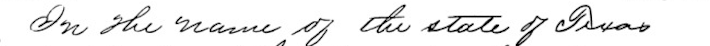

In [98]:
img_1 = Image.open('img_1.png')
img_1

In [108]:
t1 = generate_from_line('img_1.png')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [112]:
len(t1), len("In the name of the state of Texas")

(34, 33)

In [114]:
cer_metric.compute(predictions = [t1], references = ["In the name, of the state of Texas"])

0.14705882352941177

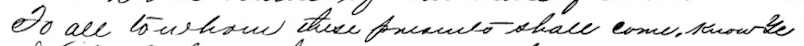

In [99]:
img_2 = Image.open('img_2.png')
img_2

In [115]:
t2 = generate_from_line('img_2.png')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [116]:
t2

'To all to whom their prisoners-shales comes, smoother'

In [117]:
cer_metric.compute(predictions = [t2], references = ["To all to whom their presnets shall come, know"])

0.30434782608695654

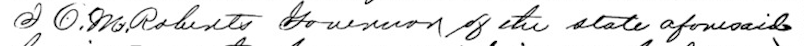

In [100]:
img_3 = Image.open('img_3.png')
img_3

In [97]:
generate_from_line('img_3.png')

'I DISPARKITY Governor of the state of which'

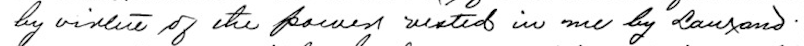

In [104]:
img_4 = Image.open('img_4.png')
img_4

In [105]:
generate_from_line('img_4.png')

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'by virtue of the former water in mer by humans.'

# Trying out with PyTessaract

In [118]:
!pip install pytesseract

In [125]:
!pip install tesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562552 sha256=691ff1c3943fafcccb0262d831afa99b796d4a00ac9b1d8211d523584b977ed4
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract


In [127]:
!echo $PATH

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [128]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,170 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120903 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [129]:
from PIL import Image
import pytesseract

# Load the image from file
img_path = 'img_2.png'
image = Image.open(img_path)

# Perform OCR on the image
text = pytesseract.image_to_string(image)

# Split the text by lines
lines = text.split('\n')

In [131]:
text

'ee yy og ee ee\n\x0c'

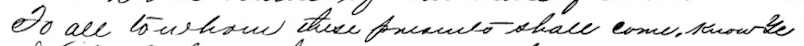

In [132]:
image